In [1]:
import os, re, magic, shutil
from glob import glob
import time, datetime
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import shutil
import warnings
import joblib

import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch, gc
from torch import nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F
import torchvision
from torchvision import transforms

import sklearn
#from skimage import io
from sklearn.model_selection import GroupKFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.ndimage import zoom

import timm
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

import wandb

In [17]:
#cecum = 1, else = 0

label_path = 'Data/라벨링데이터/'
img_path = 'Data/원천데이터/'

In [22]:
label_dir = [label_path + x for x in os.listdir(label_path) if '.json' not in x]
img_dir = [img_path + x for x in os.listdir(img_path) if '.json' not in x]

In [23]:
label_dir

['Data/라벨링데이터/KI_기아',
 'Data/라벨링데이터/RS_르노삼성',
 'Data/라벨링데이터/CH_쉐보레',
 'Data/라벨링데이터/SS_쌍용',
 'Data/라벨링데이터/AU_아우디',
 'Data/라벨링데이터/RE_르노',
 'Data/라벨링데이터/BE_벤츠',
 'Data/라벨링데이터/HY_현대',
 'Data/라벨링데이터/KG_한국지엠',
 'Data/라벨링데이터/BM_BMW']

In [15]:
random.shuffle(true_dir)
random.shuffle(false_dir)

In [16]:
print(len(true_dir))

10


In [8]:
true_label = [1]*int(len(true_dir))

In [9]:
print(true_label[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [10]:
print(len(true_label))

10


In [9]:
print(len(false_dir))

11250


In [10]:
false_label = [0]*int(len(false_dir))

In [11]:
print(false_label[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
print(len(false_label))

11250


In [13]:
whole_dir = true_dir + false_dir

In [14]:
whole_label = true_label + false_label

In [15]:
print(len(whole_dir))

12524


In [16]:
print(len(whole_label))

12524


In [17]:
trn_df = pd.DataFrame(whole_dir, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = whole_label
train = trn_df
train

,image_id,dir,label
0,V0337_0110.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
1,V0461_0017.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
2,V0404_0016.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
3,V0609_0027.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
4,V0313_0066.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
...,...,...,...
12519,V1589_2021_0139_003491.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
12520,V1829_2021_0379_003616.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
12521,V1589_2021_0139_002625.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
12522,V1589_2021_0139_002070.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0


In [18]:
train.label.value_counts()

0    11250
1     1274
Name: label, dtype: int64

In [19]:
project_name = 'cecum_classification'
user = 'honbul'
run_name = 'cecum_classification_efficientnet_lite0_size192'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


Training start with epoch 50 



/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0271: 100%|█████████████████████████████████████████████████████████| 1800/1800 [06:15<00:00,  4.80it/s]


train accuracy = 0.96706
[[8753  247]
 [ 346 8654]]


epoch 0 loss: 0.0093: 100%|███████████████████████████████████████████████████████████| 251/251 [00:42<00:00,  5.93it/s]


validation accuracy = 0.99760
[[2246    4]
 [   2  253]]


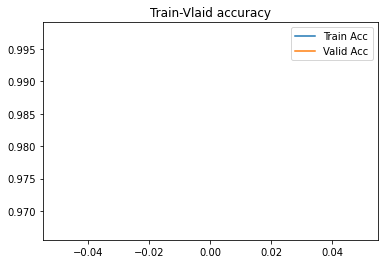

epoch 1 loss: 0.0175: 100%|█████████████████████████████████████████████████████████| 1800/1800 [06:13<00:00,  4.82it/s]


train accuracy = 0.99344
[[8951   49]
 [  69 8931]]


epoch 1 loss: 0.0088: 100%|███████████████████████████████████████████████████████████| 251/251 [00:42<00:00,  5.90it/s]


validation accuracy = 0.99840
[[2246    4]
 [   0  255]]


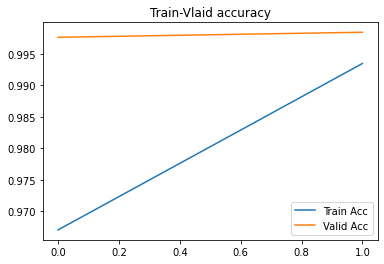

epoch 2 loss: 0.0127: 100%|█████████████████████████████████████████████████████████| 1800/1800 [06:15<00:00,  4.79it/s]


train accuracy = 0.99672
[[8974   26]
 [  33 8967]]


epoch 2 loss: 0.0043: 100%|███████████████████████████████████████████████████████████| 251/251 [00:42<00:00,  5.88it/s]


validation accuracy = 0.99960
[[2250    0]
 [   1  254]]


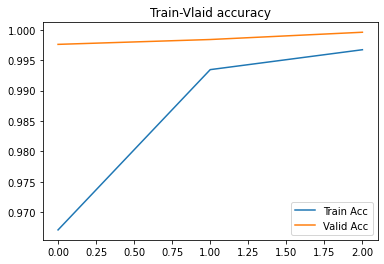

epoch 3 loss: 0.0186: 100%|█████████████████████████████████████████████████████████| 1800/1800 [06:16<00:00,  4.78it/s]


train accuracy = 0.99694
[[8978   22]
 [  33 8967]]


epoch 3 loss: 0.0049: 100%|███████████████████████████████████████████████████████████| 251/251 [00:42<00:00,  5.87it/s]


validation accuracy = 0.99840
[[2249    1]
 [   3  252]]


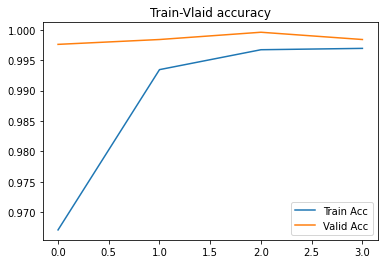

epoch 4 loss: 0.0033:  82%|██████████████████████████████████████████████▋          | 1476/1800 [05:11<01:05,  4.93it/s]

In [ ]:
%run classification_train_efficientnet.ipynb

In [ ]:
#for train, val separately

In [2]:
#cecum = 1, else = 0

true_path = '/Data/data/data_gsun/Cecum/experiment/train/cecum/'
false_path = '/Data/data/data_gsun/Cecum/experiment/train/non_cecum/'

In [3]:
true_dir = [true_path + x for x in os.listdir(true_path) if '.txt' not in x]
false_dir = [false_path + x for x in os.listdir(false_path) if '.txt' not in x]

In [4]:
random.shuffle(true_dir)
random.shuffle(false_dir)

In [5]:
print(len(true_dir))

1274


In [6]:
true_label = [1]*int(len(true_dir))

In [7]:
print(true_label[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [8]:
print(len(true_label))

1274


In [9]:
print(len(false_dir))

15000


In [10]:
false_label = [0]*int(len(false_dir))

In [11]:
print(false_label[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [12]:
print(len(false_label))

15000


In [13]:
whole_dir = true_dir + false_dir

In [14]:
whole_label = true_label + false_label

In [15]:
print(len(whole_dir))

16274


In [16]:
print(len(whole_label))

16274


In [17]:
trn_df = pd.DataFrame(whole_dir, columns=['image_id'])
trn_df['dir'] = trn_df['image_id'].apply(lambda x: os.path.dirname(x))
trn_df['image_id'] = trn_df['image_id'].apply(lambda x: os.path.basename(x))
trn_df['label'] = whole_label
train = trn_df
train

,image_id,dir,label
0,V0480_0024.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
1,V0376_0079.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
2,V0670_0048.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
3,V0307_0073.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
4,V0612_0022.png,/Data/data/data_gsun/Cecum/experiment/train/cecum,1
...,...,...,...
16269,V1743_2021_0293_000738.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16270,V1485_2021_0035_001495.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16271,V1880_2021_0430_003530.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0
16272,V1732_2021_0282_003544.png,/Data/data/data_gsun/Cecum/experiment/train/no...,0


In [18]:
train.label.value_counts()

0    15000
1     1274
Name: label, dtype: int64

In [19]:
#cecum = 1, else = 0

true_val_path = '/Data/data/data_gsun/Cecum/experiment/val/cecum/'
false_val_path = '/Data/data/data_gsun/Cecum/experiment/val/non_cecum/'

In [20]:
true_val_dir = [true_val_path + x for x in os.listdir(true_val_path) if '.txt' not in x]
false_val_dir = [false_val_path + x for x in os.listdir(false_val_path) if '.txt' not in x]

In [21]:
random.shuffle(true_val_dir)
random.shuffle(false_val_dir)

In [22]:
print(len(true_val_dir))

71


In [23]:
true_val_label = [1]*int(len(true_val_dir))

In [24]:
print(true_val_label[:10])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [25]:
print(len(true_val_label))

71


In [26]:
print(len(false_val_dir))

639


In [27]:
false_val_label = [0]*int(len(false_val_dir))

In [28]:
print(false_val_label[:10])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [29]:
print(len(false_val_label))

639


In [30]:
whole_val_dir = true_val_dir + false_val_dir

In [31]:
whole_val_label = true_val_label + false_val_label

In [32]:
print(len(whole_val_dir))

710


In [33]:
print(len(whole_val_label))

710


In [34]:
val_df = pd.DataFrame(whole_val_dir, columns=['image_id'])
val_df['dir'] = val_df['image_id'].apply(lambda x: os.path.dirname(x))
val_df['image_id'] = val_df['image_id'].apply(lambda x: os.path.basename(x))
val_df['label'] = whole_val_label
val = val_df
val

,image_id,dir,label
0,V1824_2021_0374_000004.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
1,V1533_2021_0083_000723.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
2,V1533_2021_0083_000742.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
3,V1434_2020_1204_000377.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
4,V1533_2021_0083_000750.png,/Data/data/data_gsun/Cecum/experiment/val/cecum,1
...,...,...,...
705,V1434_2020_1204_001067.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
706,V0042_2019_0042_002852.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
707,V1373_2020_1143_002984.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0
708,V0042_2019_0042_003166.png,/Data/data/data_gsun/Cecum/experiment/val/non_...,0


In [35]:
val.label.value_counts()

0    639
1     71
Name: label, dtype: int64

In [36]:
project_name = 'cecum_classification'
user = 'honbul'
run_name = 'cecum_classification_efficientnet_lite0_size192'

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: honbul. Use `wandb login --relogin` to force relogin


/home/super/endo_venv/lib/python3.8/site-packages/albumentations/augmentations/dropout/cutout.py:50: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(
epoch 0 loss: 0.0238: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:26<00:00,  4.79it/s]


train accuracy = 0.98053
[[14778   222]
 [  362 14638]]


epoch 0 loss: 0.5145: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.92it/s]


validation accuracy = 0.81408
[[512 127]
 [  5  66]]


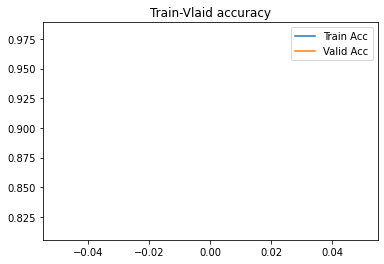

epoch 1 loss: 0.0124: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:25<00:00,  4.79it/s]


train accuracy = 0.99637
[[14946    54]
 [   55 14945]]


epoch 1 loss: 0.7367: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.10it/s]


validation accuracy = 0.70704
[[431 208]
 [  0  71]]


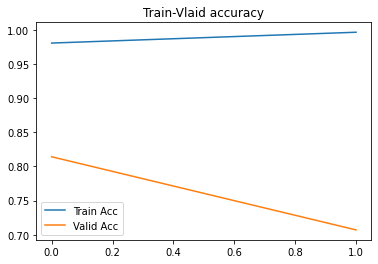

epoch 2 loss: 0.0020: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:30<00:00,  4.76it/s]


train accuracy = 0.99767
[[14959    41]
 [   29 14971]]


epoch 2 loss: 0.6676: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.18it/s]


validation accuracy = 0.80563
[[509 130]
 [  8  63]]


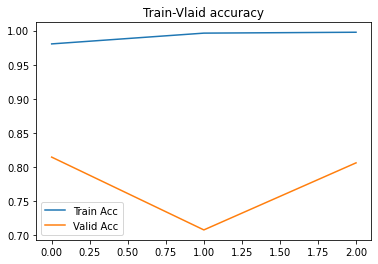

epoch 3 loss: 0.0028: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:31<00:00,  4.75it/s]


train accuracy = 0.99870
[[14980    20]
 [   19 14981]]


epoch 3 loss: 0.3945: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 20.96it/s]


validation accuracy = 0.85915
[[546  93]
 [  7  64]]


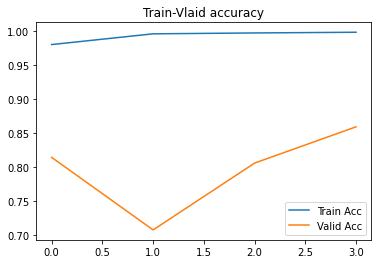

epoch 4 loss: 0.0052: 100%|█████████████████████████████████████████████████████████| 3000/3000 [10:32<00:00,  4.74it/s]


train accuracy = 0.99773
[[14961    39]
 [   29 14971]]


epoch 4 loss: 0.3124: 100%|█████████████████████████████████████████████████████████████| 71/71 [00:03<00:00, 21.07it/s]


validation accuracy = 0.88169
[[569  70]
 [ 14  57]]


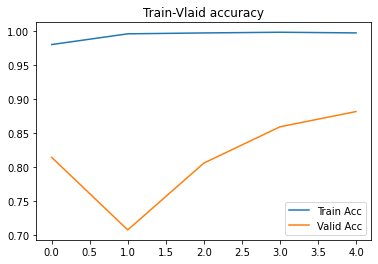

epoch 5 loss: 0.0049:  47%|██████████████████████████▊                              | 1413/3000 [04:58<05:23,  4.90it/s]

In [ ]:
%run classification_train_val_separate_efficientnet.ipynb